In [2]:
# split into a training and validation dataset
from pandas import read_csv
series = read_csv('monthly-robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 106, Validation 12


C:\Users\Brian\AppData\Local\Temp\ipykernel_12196\2220722187.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('monthly-robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


PermissionError: [Errno 13] Permission denied: 'dataset.csv'

In [3]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
X
train_size
train
test

array([], shape=(59, 0), dtype=float32)

In [4]:
# evaluate a persistence model
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True) 
# header=0 to indicate the first row as the header
# Removed squeeze=True as it is deprecated

# Extract the desired column (assuming 'Robberies' is the column name)
series = series['Robberies']  

# Convert the column to numeric, handling errors
series = pd.to_numeric(series, errors='coerce')

# The following line is causing the error and is unnecessary since the series is already 1D
# series = series.squeeze("columns") # Squeeze after reading the CSV

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [5]:
series.info()

<class 'pandas.core.series.Series'>
Index: 106 entries, "1966-01" to "1974-10"
Series name: Robberies
Non-Null Count  Dtype
--------------  -----
106 non-null    int64
dtypes: int64(1)
memory usage: 1.7+ KB


In [6]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    # Check if yhat and obs are single-element arrays and extract the value
    # If they are empty, or have multiple elements this will need to be handled
    # differently depending on the desired behavior
    # For now we are assuming single element
    try:
      print('>Predicted=%.3f, Expected=%.3f' % (yhat.item(), obs.item())) # Extract value from array using item()
    except ValueError:
      print(f">Predicted={yhat}, Expected={obs} - yhat and/or obs were not single element arrays")

>Predicted=98.000, Expected=125.000
>Predicted=125.000, Expected=155.000
>Predicted=155.000, Expected=190.000
>Predicted=190.000, Expected=236.000
>Predicted=236.000, Expected=189.000
>Predicted=189.000, Expected=174.000
>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>P

In [7]:
print(series.describe())

count    106.000000
mean     173.292453
std      112.216370
min       29.000000
25%       74.750000
50%      146.500000
75%      271.750000
max      487.000000
Name: Robberies, dtype: float64


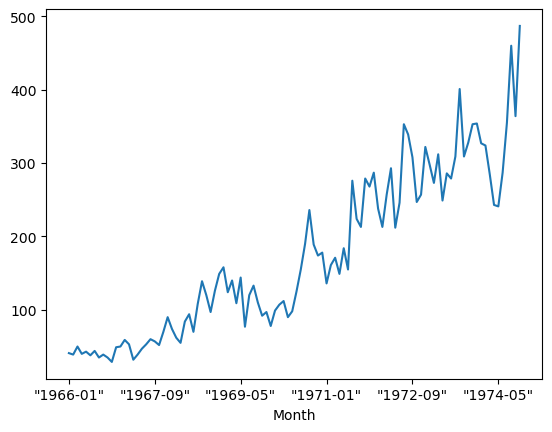

In [8]:
# line plots of time series

from matplotlib import pyplot
series.plot()
pyplot.show()

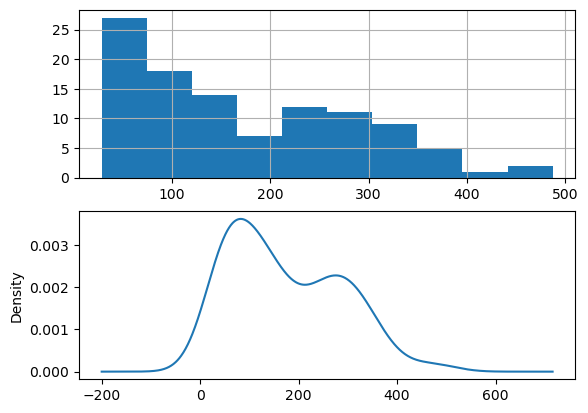

In [9]:
#Density Plot
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()


ValueError: boxplot method requires numerical columns, nothing to plot.

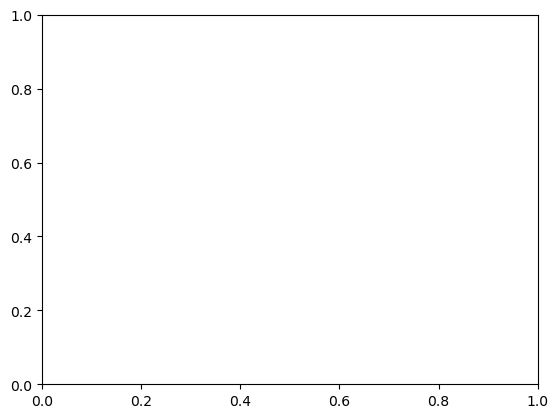

In [10]:
from pandas import Grouper, DataFrame
import matplotlib.pyplot as plt

# Assuming 'series' is your pandas Series with 'Robberies' data
# and it has a DatetimeIndex

# Convert the index to DatetimeIndex if it's not already
# Specify the format explicitly, handling errors gracefully
series.index = pd.to_datetime(series.index, errors='coerce')

# Remove rows with NaT (Not a Time) values in the index resulting from errors in conversion
series = series[series.index.notna()]

# Check index dtype and convert if needed
if not isinstance(series.index, pd.DatetimeIndex):
    # Use infer_datetime_format to automatically detect the format
    series.index = pd.to_datetime(series.index, infer_datetime_format=True, errors='coerce')
    # Remove rows with NaT (Not a Time) values in the index resulting from errors in conversion
    series = series[series.index.notna()]

# Ensure the values are numeric before grouping
series = pd.to_numeric(series, errors='coerce')  # Convert to numeric, handling errors
series = series[series.notna()]  # Remove NaN values after conversion


groups = series['1966':'1973'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
    # Convert the group values to numeric before assigning to the DataFrame
    years[name.year] = pd.to_numeric(group.values, errors='coerce') 

# Check if all columns are numeric
if not all(years.dtypes.apply(pd.api.types.is_numeric_dtype)):
    print("Warning: Some columns in 'years' are not numeric and will be excluded from the boxplot.")
    # Filter out non-numeric columns to avoid the ValueError
    years = years.select_dtypes(include=np.number)

years.boxplot()
plt.show()

## ARIMA Models

In [11]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
# create a differenced time series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)

X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]

# Check if stationary is empty or has only one unique value
if stationary.empty or stationary.nunique() <= 1:
    print("Error: The differenced series is empty or contains only one unique value. Cannot perform ADF test.")
else:
    # check if stationary
    result = adfuller(stationary)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    # save
    stationary.to_csv('stationary.csv', header=False)

Error: The differenced series is empty or contains only one unique value. Cannot perform ADF test.


C:\Users\Brian\AppData\Local\Temp\ipykernel_12196\1709504602.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return Series(diff)


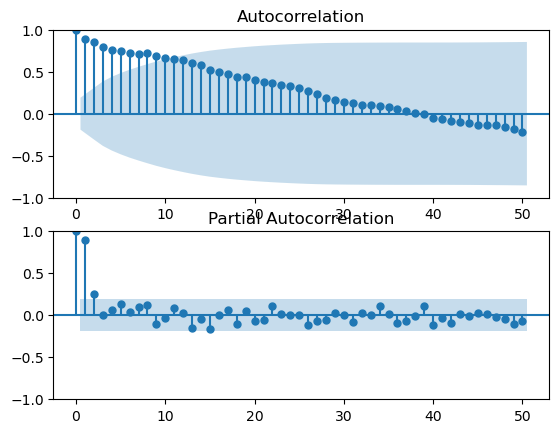

In [12]:
# ACF and PACF plots of time series

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

# Reload the original data to ensure it's not empty or corrupted
series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)['Robberies']
series = pd.to_numeric(series, errors='coerce')  # Convert to numeric
series = series[series.notna()]  # Remove NaN values

# Check if the series has enough data points for ACF/PACF calculation
if len(series) < 2:
    print("Error: The time series has less than 2 data points. ACF/PACF plots cannot be generated.")
else:
    pyplot.figure()
    pyplot.subplot(211)
    plot_acf(series, lags=50, ax=pyplot.gca())
    pyplot.subplot(212)
    plot_pacf(series, lags=50, ax=pyplot.gca())
    pyplot.show()


In [13]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
# Importing ARIMA from the correct module
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    # Using the updated ARIMA class
    model = ARIMA(history, order=(0,1,2))
    # The disp keyword is no longer supported, remove it
    model_fit = model.fit()  
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=98.432, Expected=125.000
>Predicted=112.323, Expected=155.000
>Predicted=135.557, Expected=190.000
>Predicted=171.688, Expected=236.000
>Predicted=226.431, Expected=189.000
>Predicted=192.794, Expected=174.000
>Predicted=180.501, Expected=178.000
>Predicted=180.145, Expected=136.000
>Predicted=146.354, Expected=161.000
>Predicted=161.396, Expected=171.000
>Predicted=167.374, Expected=149.000
>Predicted=152.752, Expected=184.000
>Predicted=177.310, Expected=155.000
>Predicted=158.940, Expected=276.000
>Predicted=235.871, Expected=224.000
>Predicted=230.643, Expected=213.000
>Predicted=218.055, Expected=279.000
>Predicted=254.544, Expected=268.000
>Predicted=265.092, Expected=287.000
>Predicted=279.748, Expected=238.000
>Predicted=254.835, Expected=213.000
>Predicted=227.602, Expected=257.000
>Predicted=246.564, Expected=293.000
>Predicted=275.493, Expected=212.000
>Predicted=235.295, Expected=246.000
>Predicted=243.651, Expected=353.000
>Predicted=311.751, Expected=339.000
>P

In [14]:
import warnings
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# load dataset
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


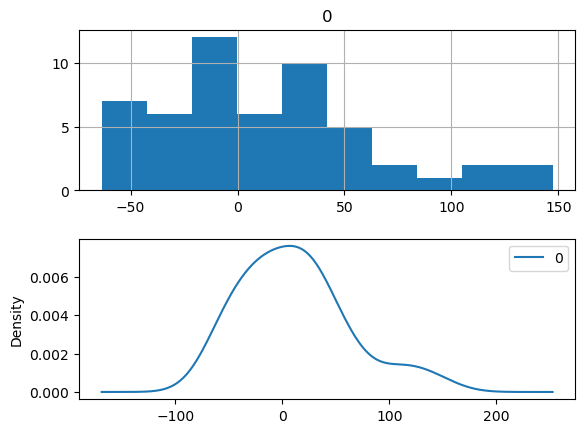

In [15]:
# plot residual errors for ARIMA model
from pandas import read_csv
from pandas import DataFrame
# Import ARIMA from the correct module
from statsmodels.tsa.arima.model import ARIMA  
from matplotlib import pyplot
# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    # Use the updated ARIMA class
    model = ARIMA(history, order=(0,1,2))  
    model_fit = model.fit()  
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

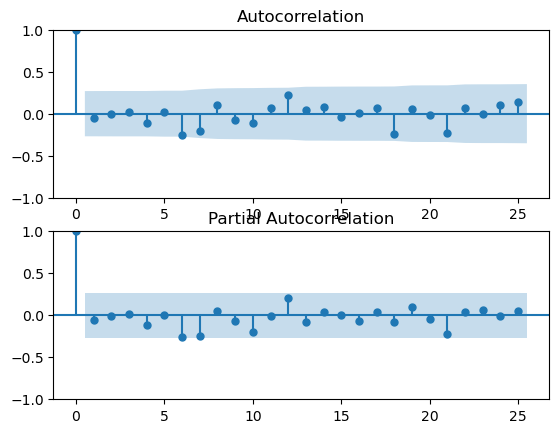

In [16]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

Lambda: 0.267730


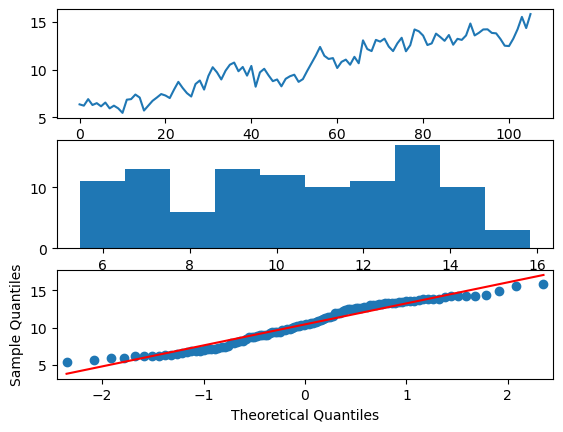

In [17]:
# Box-Cox Transformed Dataset
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)

pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

In [18]:
# invert Box-Cox transform
from math import log
from math import exp
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)


In [19]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)

train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)


>Predicted=98.676, Expected=125.000
>Predicted=113.030, Expected=155.000
>Predicted=133.852, Expected=190.000
>Predicted=163.435, Expected=236.000
>Predicted=204.818, Expected=189.000
>Predicted=185.215, Expected=174.000
>Predicted=178.851, Expected=178.000
>Predicted=179.647, Expected=136.000
>Predicted=148.339, Expected=161.000
>Predicted=162.590, Expected=171.000
>Predicted=166.683, Expected=149.000
>Predicted=153.305, Expected=184.000
>Predicted=176.213, Expected=155.000
>Predicted=158.207, Expected=276.000
>Predicted=230.320, Expected=224.000
>Predicted=215.795, Expected=213.000
>Predicted=214.427, Expected=279.000
>Predicted=254.598, Expected=268.000
>Predicted=257.724, Expected=287.000
>Predicted=275.514, Expected=238.000
>Predicted=248.492, Expected=213.000
>Predicted=227.570, Expected=257.000
>Predicted=249.501, Expected=293.000
>Predicted=274.105, Expected=212.000
>Predicted=229.144, Expected=246.000
>Predicted=245.210, Expected=353.000
>Predicted=308.602, Expected=339.000
>P

In [20]:
#Model Validation
# finalize model and save to file with workaround
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA # Importing ARIMA from the correct module
from scipy.stats import boxcox
import numpy
import pickle  # Import pickle for saving the model

# load data
series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)['Robberies']

# prepare data
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit()

# Instead of directly pickling the model_fit object, save its parameters
# and lambda value separately.
model_params = model_fit.params
# Get the full model order (p, d, q) instead of just 'ar'
# model_order = model_fit.model_orders  # This will give you a dictionary with p, d, q values
# Since you know the order, directly store it as a tuple
model_order = (0, 1, 2) 
# save model parameters and lambda value using numpy
numpy.save('model_params.npy', model_params)
# Save the model order as a tuple instead of a dictionary
numpy.save('model_order.npy', model_order, allow_pickle=True)  # Save the full model_orders dictionary
numpy.save('model_lambda.npy', lam)


# To load the model later, you would do the following:
loaded_params = numpy.load('model_params.npy')
# Load the model order and convert it to a tuple
loaded_order = tuple(numpy.load('model_order.npy', allow_pickle=True)) # Convert to tuple with p, d, q
# loaded_order_dict = numpy.load('model_order.npy', allow_pickle=True).item() # Load as dictionary
# loaded_order = tuple(loaded_order_dict.values()) # Get values from dictionary as tuple
loaded_lambda = numpy.load('model_lambda.npy')
loaded_model = ARIMA(transformed, order=loaded_order)
loaded_model_fit = loaded_model.fit(start_params=loaded_params) # Initialize with saved parameters

## Make Prediction

In [21]:
# Make Prediction
# load the finalized model and make a prediction
from statsmodels.tsa.arima.model import ARIMA
from math import exp
from math import log
import numpy
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

# Load the saved model parameters and lambda value
loaded_params = numpy.load('model_params.npy')
loaded_order = tuple(numpy.load('model_order.npy', allow_pickle=True))
loaded_lambda = numpy.load('model_lambda.npy')

# Load the original data (you might need to adjust the path)
series = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)['Robberies']
X = series.values
X = X.astype('float32')
transformed, _ = boxcox(X) # Use original lambda for consistency

# Create a new ARIMA model with the loaded order and fit it using the loaded parameters
loaded_model = ARIMA(transformed, order=loaded_order)
model_fit = loaded_model.fit(start_params=loaded_params)

# Make the prediction
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, loaded_lambda)
print('Predicted: %.3f' % yhat)

Predicted: 446.242


## Validate Model

>Predicted=446.242, Expected=452.000
>Predicted=435.179, Expected=391.000
>Predicted=403.905, Expected=500.000
>Predicted=471.476, Expected=451.000
>Predicted=447.025, Expected=375.000
>Predicted=400.308, Expected=372.000
>Predicted=390.123, Expected=302.000
>Predicted=332.055, Expected=316.000
>Predicted=331.147, Expected=398.000
>Predicted=378.640, Expected=394.000
>Predicted=379.398, Expected=431.000
>Predicted=411.572, Expected=431.000
RMSE: 52.754


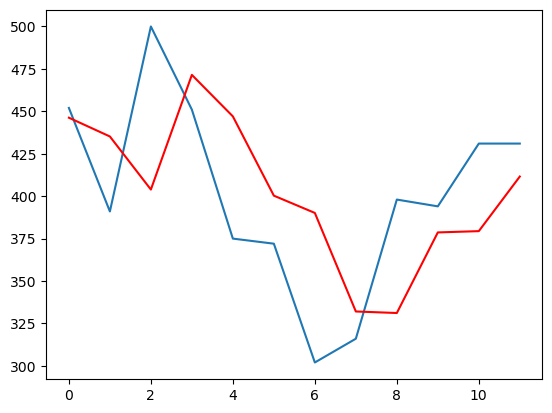

In [22]:
##Validate Model
# evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.arima.model import ARIMAResults # This line is removed
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy

# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

# load and prepare datasets
dataset = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)['Robberies']
X = dataset.values.astype('float32')
history = [x for x in X]
# Assuming validation.csv has no header and the first column is the data
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True)
# Access the robberies data using the column index (e.g., 0 for the first column)

# Instead of using validation[1], which tries to access a column named '1', 
# we access the first column (index 0) which likely contains the robberies data.

# ---CHANGE START---
# The previous approach assumed no header but treated the first row as data
# Now we specify header=0 to explicitly treat the first row as a header
validation = read_csv('validation.csv', header=0, index_col=0, parse_dates=True) 

# Access the data using the column name, assuming it's 'Robberies'
y = validation['Robberies'].values.astype('float32') 
# ---CHANGE END---


# load model parameters and lambda
loaded_params = numpy.load('model_params.npy')
loaded_order = tuple(numpy.load('model_order.npy', allow_pickle=True))
loaded_lambda = numpy.load('model_lambda.npy')

# Create a new ARIMA model with the loaded order and fit it using the loaded parameters
# model_fit = ARIMAResults.load('model.pkl') # This line is removed
# lam = numpy.load('model_lambda.npy') # This line is moved up

# make first prediction
predictions = list()

# Create a new ARIMA model and fit it using the loaded parameters
# The first prediction will be based on the original dataset
transformed, _ = boxcox(history)
model = ARIMA(transformed, order=loaded_order)
model_fit = model.fit(start_params=loaded_params)  # Initialize with saved parameters
yhat = model_fit.forecast()[0]

yhat = boxcox_inverse(yhat, loaded_lambda)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.legend()
pyplot.plot(predictions, color='red')
pyplot.show()